# DATA PREPROCESSING

In [2]:
import pandas as pd
import numpy as np

## <center/> ECOBICI

In [38]:
# I only want columns related to datetimes

df2 = pd.read_csv('2020-03.csv',
            na_values=[0, "NaN"],
            usecols=['Fecha_Retiro', 'Hora_Retiro', 'Fecha_Arribo', 'Hora_Arribo']
            )
# This will append DataFrames from April to June to the already existing DataFrame from March
ecobicis = ['2020-04.csv', '2020-05.csv', '2020-06.csv']

for i in ecobicis:
    temp_df = pd.read_csv('{}'.format(i),
            na_values=[0, "NaN"],
            usecols=['Fecha_Retiro', 'Hora_Retiro', 'Fecha_Arribo', 'Hora_Arribo']
            )
    df2 = df2.append(temp_df, ignore_index=True)

# We don't want duplicated rows 🤮
df2 = df2.drop_duplicates(keep="first").reset_index(drop=True)

In [3]:
# I calculate the difference because I want to select only valid travels

**I calculate the travel duration so I can only keep _valid_ dates**

In [39]:
'''
Given the date format, I calculate the duration of the travels by
joining date and time as string, and then converting them to datetime
to substract the end of the travel minus the start of the travel.
As the result is a timedelta, I can only convert it to seconds,
but in the end I prefer working with minutes
'''

df2["diff"] = (
        pd.to_datetime(
            df2["Fecha_Arribo"].astype(str) + " " + df2["Hora_Arribo"].astype(str),
            format="%d/%m/%Y %H:%M:%S",
        )
        - pd.to_datetime(
            df2["Fecha_Retiro"].astype(str) + " " + df2["Hora_Retiro"].astype(str),
            format="%d/%m/%Y %H:%M:%S",
        )
    ).dt.total_seconds() / 60

In [40]:
# keep travels that lasted more than 2.5mins but less than 2hrs
valid_travels = (df2['diff'] > 0) & (df2['diff'] < 120)
df2 = df2[valid_travels].reset_index(drop=True)

In [41]:
# I only want date from datetime
#### Proly df[column with datetime].dt.date would also work XD
df2['Fecha_Retiro'] = pd.to_datetime(df2['Fecha_Retiro'], format="%d/%m/%Y")
df2['Fecha_Arribo'] = pd.to_datetime(df2['Fecha_Arribo'], format="%d/%m/%Y")

In [42]:
cont_bicis = df2.groupby(by=df2['Fecha_Arribo'], as_index=True, ).count()['diff']

## covid-19 cdmx

In [24]:
# I sum the daily total sum of confirmed cases in all entities
tktvid = pd.read_csv('casos_covid.csv').drop(columns=['cve_ent', 'poblacion']).sum()

In [26]:
tktvid.index = pd.to_datetime(tktvid.index, format='%d-%m-%Y')

In [35]:
tkt = tktvid[tktvid.index < '2020-07-01']

In [113]:
tkt1 = tkt[(tkt.index > '2020-03-11') & (tkt.index < '2020-07-01')]

## Vehicular transit reduction

In [67]:
hola = pd.read_csv('diferencias-porcentuales-en-el-transito-vehicular-en-la-cdmx.csv', index_col='FECHA')[['00 TOTAL CDMX']]
hola.index = pd.to_datetime(hola.index, format='%Y-%m-%d')

In [101]:
f = pd.concat([
    cont_bicis['2020-03-11' < cont_bicis.index], 
    hola[('2020-03-11' < hola.index) & ('2020-07-01' > hola.index)]
            ],
        axis=1, ).interpolate() # there are some missing values, but they can be filled bc they behave linearly

In [107]:
f.columns = ['usuarios_bici', 'reduccion_trafico']

# DATA VISUALIZATION

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

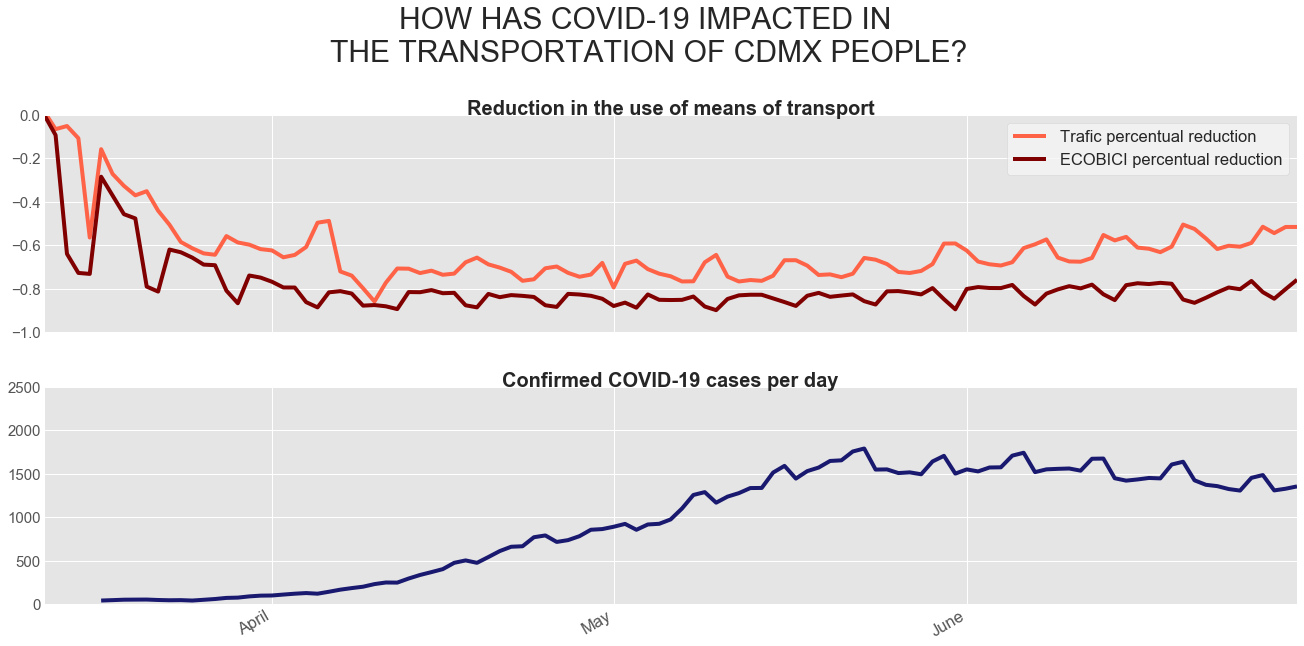

In [308]:
fig, (ax4, ax5) = plt.subplots(2, sharex=True, figsize=(20,10))

# Title of the graph
fig.suptitle('HOW HAS COVID-19 IMPACTED IN \nTHE TRANSPORTATION OF CDMX PEOPLE?', y=1.03, fontsize=30)

# :D
plt.style.use('ggplot')

# ???
fig.subplots_adjust(hspace=0.25)


# Upper graph

# Divided by 100 so its range is 0 -> -1
ax4.plot(f['reduccion_trafico']/100, label='Trafic percentual reduction', c='tomato')
# 30919.0 is the highest value, so it will considered as the starting point
ax4.plot((f['usuarios_bici']/30919.0)-1, label='ECOBICI percentual reduction', c='maroon')
ax4.set_title('Reduction in the use of means of transport', pad=0, fontsize=20, fontweight='heavy')
ax4.legend(facecolor='whitesmoke', fancybox=True)

# Lower graph
ax5.plot(tkt1.rolling(6).mean(), c='midnightblue') # to smooth the peaks
ax5.set_title('Confirmed COVID-19 cases per day', pad=0, fontsize=20, fontweight='heavy');

# x-axis limits
ax4.set_xlim(tkt1.index[0], tkt1.index[-1])
ax5.set_xlim(tkt1.index[0], tkt1.index[-1])

# y-axis_limit
ax4.set_ylim(-1,0)
ax5.set_ylim(0,2500)

# x-axis values
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%B')

# PARA EL GRID
ax4.xaxis.set_major_locator(months)
ax4.xaxis.set_major_formatter(months_fmt)
ax5.tick_params(axis='y', which='major', labelsize=15)


# x-axis slightly de lado jeje
fig.autofmt_xdate()


plt.savefig('preliminar4.png', dpi=300, bbox_inches='tight')

In [309]:
# made by Oswaldo Chan